# Задача А

Будем проводить численный эксперимент по моделированию температурных конфигураций системы нагревающихся блоков, способных взаимодействовать с ближайшими соседями. Будем считать что блоки подвергаются нагреванию прямоугольным сигналом переменной скважности, причём выделяются два основных режима работы: нормальный и интенсивный. При достижении блоком некоторой критической температуры, блок должен переходить в устранимый отказ — при достижении остывающим отключенным блоком пороговой температуры, отказ по перегреву снимается и блок возвращается в работу. Кроме устранимых отказов по перегреву блоки могут переходить в безусловный отказ, причем среднее время наработки на отказ должно даваться распределением Вейбулла. Коэффициенты теплоёмкости и коэффициенты теплопередачи незначительно осциллируют во времени относительно своих средних значений.

В качестве baseline-решения будем решать следующую систему ОДУ:

$\dot T_i = -\gamma_i (T_i - T_{c}) + \alpha_i (T_i) + \sum_{j} A_{ij} (T_i-T_j)$,

$T_i (t=t_0) = T_i^{(0)}$,

где 

$T_i$ --- температура $i$-го блока, 

$\gamma_i$ ($\gamma_i \geq 0$) --- коэффициент "остывания" $i$-го блока,

$T_{c}$ --- температура теплоносителя в системе охлаждения



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import random
from scipy.stats import weibull_min
from scipy import signal
from scipy.integrate import odeint

**Настраиваемые глобальные параметры:**

In [3]:
N_BLC = 16
TMIN = 20
TMAX = 60
TEXT = 150
TC = TMIN*0.9
MODELINGTIME = 1000
Nt = 10000
DUTYCYCLE_COMMON = 0.50
DUTYCYCLE_INTENSE = 0.95
HFREQ = 0.5
COOLING_FACTOR = 0.07
HEATING_FACTOR = 0.04
INTERACTING_FACTOR = 0.005
N_TRAJECTORIES = 10

где

```N_BLC``` --- число блоков в системе (должно быть квадратом натурального числа: 4, 9, 16, 25, ...),

```TMAX``` и ```TMIN``` --- температура отключения блока по перегреву и температура восстановления работоспособности соответственно; температуру восстановления будем идентифицировать с температурой теплоносителя системы охлаждения + 10%, 

```MODELINGTIME``` --- горизонт моделирования по времени,

```Nt``` --- число узлов по времени, 

```DUTYCYCLE_COMMON``` и ```DUTYCYCLE_INTENSE``` --- скважность "нагревающего" сигнала в обычном и теплонапряженном режиме работы соответственно

```HFREQ``` --- частота "нагревающего" сигнала

Протестируем вид "нагревающего" сигнала

In [4]:
t = np.linspace(0, MODELINGTIME, Nt, endpoint=False)
common_sig = signal.square(2 * np.pi * HFREQ * t, duty=DUTYCYCLE_COMMON)
intens_sig = signal.square(2 * np.pi * HFREQ * t, duty=DUTYCYCLE_INTENSE)

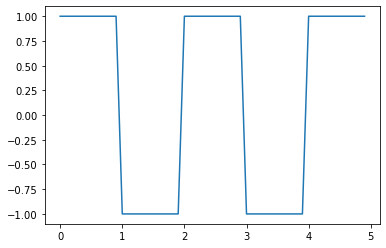

In [5]:
plt.plot(t[0:50], common_sig[0:50])

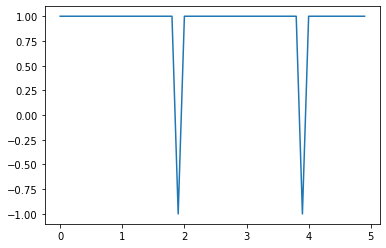

In [6]:
plt.plot(t[0:50], intens_sig[0:50])

Напишем генератор "нагревающего" сигнала, который будет давать сигнал с заданной долей интенсивного сигнала с высокой скважностью за период наблюдения.

In [7]:
def get_heating_signal(_t, _intense_proportion):
    duty_list = random.choices(population=[DUTYCYCLE_COMMON, DUTYCYCLE_INTENSE],
                               weights=[1.0-_intense_proportion, _intense_proportion],
                               k=Nt)
    mods = (np.array(duty_list) == DUTYCYCLE_INTENSE).astype(int)
    return 0.5*(signal.square(2 * np.pi * HFREQ * _t, duty=duty_list) + 1), mods

<BarContainer object of 200 artists>

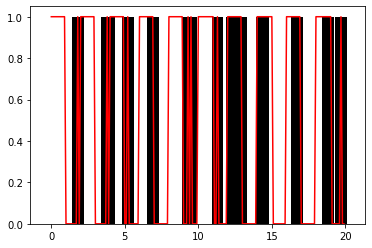

In [8]:
sig, mods = get_heating_signal(t, 0.05)
plt.plot(t[0:200], sig[0:200], color='r')
plt.bar(t[0:200], mods[0:200], color='black')

<BarContainer object of 200 artists>

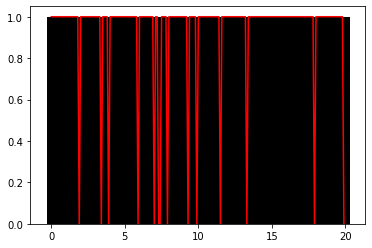

In [9]:
sig, mods = get_heating_signal(t, 0.95)
plt.plot(t[0:200], sig[0:200], color='r')
plt.bar(t[0:200], mods[0:200], color='black')

Определим матрицу взаимодействия блоков $A_{ij}$. Как легко заметить, это должна быть квадратная матрица порядка $\mathrm{N\_BLC} \times \mathrm{N\_BLC}$ с нулями на главной диагонали. Симметричная матрица $A_{ij} = A_{ji}$ соответствует ситуации, в которых блоки оказывают друг на друга одинаковое тепловое влияние, что не является обязательным условием --- введение асимметрии в коэффициентах можно будет интерпретировать в качестве наличия конвективных потоков.

В качестве простейшей модели будем считать что блоки располагаются на прямоугольной квадратной сетке. В случае взаимодействия только с ближайшими соседями, матрица $A_{ij}$ принимает простой 4-диагональный вид:


In [10]:
row_len = np.sqrt(N_BLC).astype(int)
A = np.diag(np.ones(N_BLC)[:-row_len], k=-row_len) + np.diag(np.ones(N_BLC)[:-row_len], k=row_len)
tmp=np.ones(N_BLC)
tmp[row_len-1::row_len] = 0.0
A += np.diag(tmp[:-1], k=-1) + np.diag(tmp[:-1], k=1)

In [11]:
A.astype(int)

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

NOTE: представленная матрица смежности предполагает, что блоки располагаются в квадратной решетке $\sqrt{\mathrm{N\_BLC}}$ размером. Блоки нумеруются построчно.

In [12]:
np.arange(N_BLC).reshape(row_len,row_len) # индексы блоков в решётке

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

Определим столбец $\gamma_i$, задающий относительную "скорость" остывания блока под воздействием системы охлаждения. Потребуем, чтобы эффективность системы охлаждения на боковых гранях решётки была на 5% ниже общей, а на верхней грани ниже на 10%. 

In [13]:
gamma = np.ones(N_BLC)
gamma[0:row_len] -= 0.10 * np.ones(row_len)
gamma[0::row_len] -= 0.05 * np.ones(row_len)
gamma[row_len-1::row_len] -= 0.05 * np.ones(row_len)
gamma *= COOLING_FACTOR
gamma.reshape(row_len,row_len)

array([[0.0595, 0.063 , 0.063 , 0.0595],
       [0.0665, 0.07  , 0.07  , 0.0665],
       [0.0665, 0.07  , 0.07  , 0.0665],
       [0.0665, 0.07  , 0.07  , 0.0665]])

Опеределим столбец начальных условий $T_i^{(0)}$ для температур блоков.

In [14]:
def get_init_T():
    return np.random.uniform(TMIN,TMAX,N_BLC)
T_init = get_init_T()
T_init.reshape(row_len,row_len)

array([[21.63603024, 50.27083237, 32.82652355, 38.89378437],
       [33.68121326, 33.60998631, 30.84249555, 37.27933083],
       [57.58847309, 27.34424278, 42.79183687, 26.78373091],
       [54.69799757, 26.20771981, 56.30688727, 52.94400742]])

С каждым из блоков нужно связать его время наработки на отказ. Будем считать, что среднее время наработки на отказ даётся из распределения Вейбулла.

***UPD:***
Как мы уже успели обсудить, для придания смысла "агретированию" необходимо приписать большую вероятность отказа тем блокам, которые дольше провели в нагретом состоянии.В качестве такой характеристики "наработки" предлагаю считать (нормированную на текущее время) кумулятивную сумму значений температур блоков. Далее предлагаю взять точки случайно взятые из распределения Вейбулла, упорядочить их по возрастанию и разбить на группы по числу блоков в системе. Вычисляя теперь нашу интегральную характеристику "тепловой наработки", мы можем задать и динамически обновлять упорядочение на множестве блоков.В соответствие с данным упорядочением мы можем теперь легко определить фактическое время перехода конкретного блока в безусловный отказ.

In [15]:
# collect arranged Weibull samples array
k = 10.3     # shape
lam = MODELINGTIME*0.9   # scale


def get_failure_T():
    return np.sort(weibull_min.rvs(k, loc=0, scale=lam, size=N_BLC))


T_failure = get_failure_T()
T_failure.reshape(row_len,row_len)

array([[630.26856913, 706.62135658, 772.86847686, 775.62214723],
       [817.80172745, 842.12351485, 845.38352827, 852.25083816],
       [858.99557585, 869.52673884, 872.57496473, 882.43240736],
       [886.48678061, 933.29935587, 966.67538894, 995.9542756 ]])

(array([1., 0., 1., 2., 0., 3., 5., 1., 1., 2.]),
 array([630.26856913, 666.83713977, 703.40571042, 739.97428107,
        776.54285171, 813.11142236, 849.67999301, 886.24856365,
        922.8171343 , 959.38570495, 995.9542756 ]),
 <BarContainer object of 10 artists>)

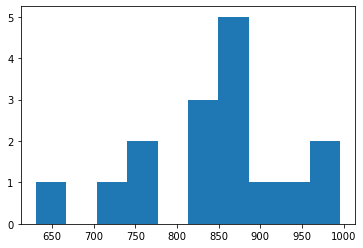

In [16]:
plt.hist(T_failure)

In [17]:
def update_stat(_T, _t, _summs, _strats):
    for i in range(N_BLC):
        _summs[i] += _T[i]
    _strats = np.argsort(_summs)
    return _summs, _strats

Перейдём к части с решением ОДУ в виде

$ \dot{\vec{T}} = \vec{f}(\vec{T}, t, ...)$

In [18]:
def rhs(_T, _t, _failure_flags, _heating_signal, _t_full, _summs, _strats, _state_stat, _t_stat):
    _summs, _strats = update_stat(_T, _t, _summs, _strats)
    for i in range(N_BLC):
        if (_T[i] > TMAX):
            _failure_flags[i] = True
        elif ((_T[i] <= TMIN) and _failure_flags[i]):
            _failure_flags[i] = False
        if (_t >= T_failure[_strats][i]):
            _failure_flags[i] = True
            _summs[i] = np.inf  # костыль

    tmp_cooling = -np.multiply(gamma, (_T - TC))

    alive_factor = np.invert(_failure_flags).astype(int)
    _state_stat.append(alive_factor)
    _t_stat.append(_t)
    
    tmp_heating = alive_factor * \
                  HEATING_FACTOR * \
                  _heating_signal[np.argmin(np.abs(_t_full - _t))] * \
                  (TEXT - _T) # костыль
    
    
    tmp_interacting = INTERACTING_FACTOR * \
                      np.array([sum([ A[i][j] * (_T[j] - _T[i]) for j in range(N_BLC)]) for i in range(N_BLC)])
    
    return tmp_cooling + tmp_heating + tmp_interacting

In [19]:
from scipy import interpolate # костыль

In [20]:
# костыль
def extract_blc_state(_state_stat, _t_stat, _t):
    state = np.full((Nt, N_BLC), False)
    timevalue = np.array(_t_stat)
    for i in range(N_BLC):
        state_value = np.array(_state_stat)[:, i]
        x = timevalue
        y = state_value
        f = interpolate.interp1d(x, y, kind='nearest')
        state[:, i] = f(_t)
    return state

In [21]:
def generate_trajectory(_intensity):
    
    failure_flags = np.full(N_BLC, False)
    heating_signal, mods = get_heating_signal(t, _intensity)
    
    T_init = get_init_T()
    T_failure = get_failure_T()
    
    cumsumms = np.zeros(N_BLC)
    strats = np.zeros(N_BLC, dtype=int)
    state_stat = []
    t_stat = []
    
    T = odeint(rhs, T_init, t, args=(failure_flags, heating_signal, t, cumsumms, strats, state_stat, t_stat))
    
    blc_state = extract_blc_state(state_stat, t_stat, t)
    full_state = np.sum(blc_state, axis=1) > 0.9*N_BLC
    
    plt.plot(t, T[:, :])
    names_list = ['t', 'Mode', *['T{}'.format(i) for i in range(N_BLC)],
                  *['StateBlc{}'.format(i) for i in range(N_BLC)], 'State'
                 ]
    df = pd.DataFrame(columns = names_list)
    df['t'] = np.array(t)
    df['Mode'] = mods
    df['State'] = full_state
    for i in range(N_BLC):
        df['StateBlc{}'.format(i)] = blc_state[:, i]
        df['T{}'.format(i)] = T[:, i]
    return df

,t,Mode,T0,T1,T2,T3,T4,T5,T6,T7,...,StateBlc7,StateBlc8,StateBlc9,StateBlc10,StateBlc11,StateBlc12,StateBlc13,StateBlc14,StateBlc15,State
0,0.0,1,50.958957,35.892259,57.942431,59.779143,55.876092,39.600680,40.899693,34.523143,...,True,True,True,True,True,True,True,True,True,True
1,0.1,1,51.152993,36.254390,58.040003,59.877474,55.977663,39.903812,41.171660,34.901274,...,True,True,True,True,True,True,True,True,True,True
2,0.2,0,51.345144,36.612567,58.136782,59.852111,56.078452,40.203429,41.440741,35.275035,...,True,True,True,True,True,True,True,True,True,True
3,0.3,1,51.535431,36.966833,58.232644,59.590969,56.178463,40.499572,41.706966,35.644348,...,True,True,True,True,True,True,True,True,True,True
4,0.4,1,51.723870,37.317231,58.327559,59.331867,56.277701,40.792283,41.970363,36.009228,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999.5,1,18.689031,18.186041,18.036943,18.014698,18.161904,18.049160,18.029973,18.068420,...,False,False,False,False,False,False,False,False,False,False
9996,999.6,1,18.684432,18.184980,18.036770,18.014649,18.160971,18.048927,18.029863,18.068202,...,False,False,False,False,False,False,False,False,False,False
9997,999.7,1,18.679864,18.183925,18.036599,18.014600,18.160044,18.048694,18.029753,18.067985,...,False,False,False,False,False,False,False,False,False,False
9998,999.8,1,18.675326,18.182876,18.036428,18.014550,18.159122,18.048462,18.029644,18.067767,...,False,False,False,False,False,False,False,False,False,False


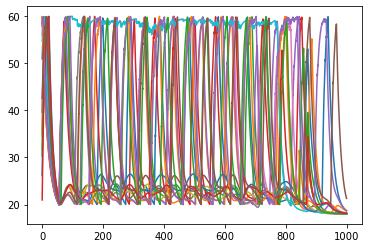

In [22]:
generate_trajectory(0.95)

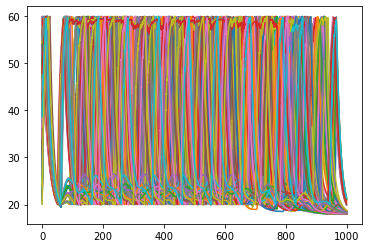

In [23]:
trh = []
for traj_id in range(N_TRAJECTORIES):
    trajectory = generate_trajectory(0.95)
    trh.append(trajectory)
    # trajectory.to_csv("TRAJECTORIES/trajectory{}.csv".format(traj_id), index=False)

[0 1] [8005 1995]


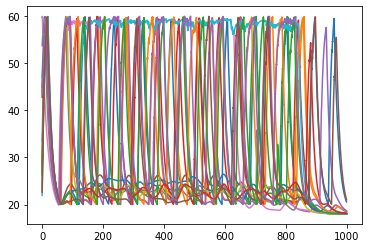

In [24]:
traj = generate_trajectory(0.95)
t_rab = traj['StateBlc{}'.format(0)].to_numpy().astype(int).sum()/Nt*MODELINGTIME
unique, counts = np.unique(traj['StateBlc{}'.format(0)].to_numpy().astype(int), return_counts=True)
print(unique, counts)

In [25]:
t_rab = np.zeros((N_TRAJECTORIES, N_BLC))
t_otval = np.full((N_TRAJECTORIES, N_BLC), float(MODELINGTIME))
for traj_id, traj in enumerate(trh):
    for blc_id in range(N_BLC):
        t_rab[traj_id, blc_id] = traj['StateBlc{}'.format(blc_id)].to_numpy().astype(int).sum()/Nt*MODELINGTIME
t_otval -= t_rab
t_rab.mean(axis=0)

array([203.25, 150.64, 128.8 , 186.99, 167.08, 286.73, 333.35, 145.86,
       119.56, 394.88, 311.6 , 151.35, 234.19, 182.84, 232.24, 261.97])

In [26]:
K_g = t_rab / MODELINGTIME

In [27]:
from scipy import integrate

In [28]:
p = lambda x: weibull_min.pdf(x, k, loc=0, scale=lam)
P = np.array([(1 - integrate.quad(p, 0, _intT)[0]) for _intT in t])

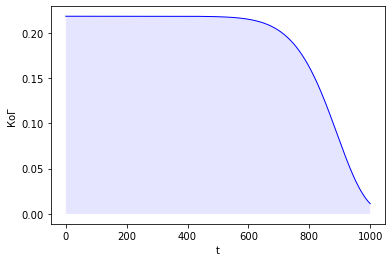

In [29]:
plt.plot(t, P*K_g.mean(), 'b', linewidth=1)
plt.fill_between(t, t * 0, P*K_g.mean(), facecolor='b', alpha=0.1)
plt.ylabel('КоГ')
plt.xlabel('t')
plt.show()

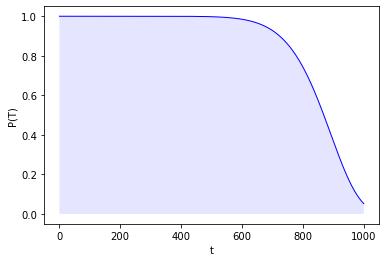

In [30]:
plt.plot(t, P, 'b', linewidth=1)
plt.fill_between(t, t * 0, P, facecolor='b', alpha=0.1)
plt.ylabel('P(T)')
plt.xlabel('t')
plt.show()